In [180]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
#from generate_data import *
import matplotlib.pyplot as plt

In [181]:
####
#read in data
####
col = ["1","2","3","4","5","6"]
X = pd.read_csv("./data.csv",sep=",",names = col)
Y = pd.read_csv("./label.csv",sep=",",names = ["label"])

In [200]:

#####################
# Set parameters
#####################

# Data params
noise_var = 0
num_datapoints = len(X)
test_size = 0.2
num_train = int((1-test_size) * num_datapoints)
num_train = num_train-num_train%100

# Network params
input_size = 6   #length of input vector x
batch_block_size = 100
# If `per_element` is True, then LSTM reads in one timestep at a time.
per_element = True
if per_element:
    lstm_input_size = 1
else:
    lstm_input_size = input_size
# size of hidden layers
h1 = 32    #hiddle dimension
output_dim = 1
num_layers = 4
learning_rate = 1e-2     #learning rate
num_epochs = 1000     # training interation times

In [201]:
#####################
# Generate data
#####################
# make training and test sets in torch
X_train = X.loc[0:num_train-1,:]
y_train = Y.loc[0:num_train-1,:]
X_test = X.loc[num_train:,:]
y_test = Y.loc[num_train:,:]

X_train = torch.tensor(X_train.values,dtype=torch.float)
X_test = torch.tensor(X_test.values,dtype=torch.float)
y_train = torch.tensor(y_train.values,dtype=torch.float).view(-1)
y_test = torch.tensor(y_test.values,dtype=torch.float).view(-1)

X_train = X_train.view([input_size, -1, 1])
X_test = X_test.view([input_size, -1, 1])


In [202]:
print(X_train.size(),num_train)

(torch.Size([6, 2000, 1]), 2000)


In [203]:
#####################
# Build model
#####################

# Here we define our model as a class
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)

model = LSTM(lstm_input_size, h1, batch_size=num_train, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss(size_average=False)

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)




In [204]:
# model.hidden = model.init_hidden()
# y_pred = model(X_train)
# print (y_pred)

In [205]:

#####################
# Train model
#####################

hist = np.zeros(num_epochs)

model.hidden = model.init_hidden()
for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_pred = model(X_train)

    loss = loss_fn(y_pred, y_train)
    if t % 100 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
        print("mean: ", y_pred.mean())
        print(y_pred)
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()



('Epoch ', 0, 'MSE: ', 6531080.5)
('mean: ', tensor(-0.0502, grad_fn=<MeanBackward0>))
tensor([-0.0502, -0.0502, -0.0502,  ..., -0.0502, -0.0501, -0.0501],
       grad_fn=<ViewBackward>)
('Epoch ', 100, 'MSE: ', 1444847.5)
('mean: ', tensor(32.1165, grad_fn=<MeanBackward0>))
tensor([32.1164, 32.1164, 32.1164,  ..., 32.1164, 32.1164, 32.1164],
       grad_fn=<ViewBackward>)
('Epoch ', 200, 'MSE: ', 446345.15625)
('mean: ', tensor(48.4562, grad_fn=<MeanBackward0>))
tensor([48.4562, 48.4562, 48.4562,  ..., 48.4562, 48.4562, 48.4562],
       grad_fn=<ViewBackward>)
('Epoch ', 300, 'MSE: ', 349361.46875)
('mean: ', tensor(54.1416, grad_fn=<MeanBackward0>))
tensor([54.1416, 54.1416, 54.1416,  ..., 54.1416, 54.1416, 54.1416],
       grad_fn=<ViewBackward>)
('Epoch ', 400, 'MSE: ', 345384.6875)
('mean: ', tensor(55.3809, grad_fn=<MeanBackward0>))
tensor([55.3808, 55.3808, 55.3808,  ..., 55.3808, 55.3808, 55.3808],
       grad_fn=<ViewBackward>)
('Epoch ', 500, 'MSE: ', 345318.34375)
('mean: ',

[32.33136  32.33138  32.33137  ... 32.331398 32.331398 32.331406]


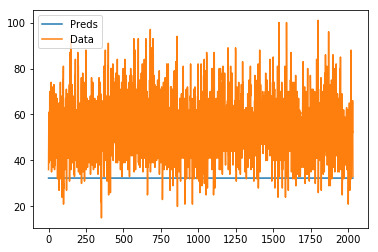

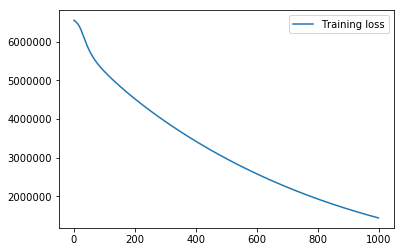

In [164]:
#####################
# Plot preds and performance
#####################

plt.plot(y_pred.detach().numpy(), label="Preds")
print(y_pred.detach().numpy())
plt.plot(y_train.detach().numpy(), label="Data")
plt.legend()
plt.show()

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()